## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 3

A testbed for making Fig.3 :  the 4 x 4 histogram plot. It shows that   0   < log(tau) < 1.7 (short timescales bin), does not exhibit any variability, because chi_ij for qso and stars is almost undistinguishable for uncorrected points. 

The files in  SF_plotting/Histogram_r_cut_starsB_qso/    are described in README. 

To make them  one would run points 1-10  (numeration inherited from CRTS_sel_g_cut_vs_r_cut.ipynb )   for different mag cuts :  17-18 ,  18-18.5 ,  18.5-19 , thus producing  8 files per cut (4 for qso,  4 for Blue Stars ) . 

Thus saved in SF_plotting/Histogram_r_cut_starsB_qso/   , one would read them all in 10)a) , and plot the histogram. 

NOTE:  that these points have no correction , they have exactly the same e_ij as from master files . |



In [3]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

In [2]:
def get_qso_catalog(catalog):
    if catalog == 's82drw':
        File = 'CRTS_SDSS_cross_matched_qso_s82drw_catalog.txt'
    if catalog == 'DB_QSO':
        File = 'CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File, dtype=str)
    qso_catalog = {}
    print 'Zipping CRTS-SDSS quasars catalog from ', File, ' ...'
    for label, column in zip(colnames, datatable.T):
        qso_catalog[label] = column
    
    print 'Read in ', len(qso_catalog['redshift']), ', quasars from CRTS'
    return  colnames, qso_catalog
    
def get_stars_catalog():
    File = 'CRTS_SDSS_cross_matched_stars_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    stars_catalog = {}
    print 'zipping CRTS-SDSS stars catalog...'
    for label, column in zip(colnames, datatable.T):
        stars_catalog[label] = column
        
    return  colnames, stars_catalog

cols1, qso_cat = get_qso_catalog(catalog='DB_QSO') 
cols2 , star_cat= get_stars_catalog()

# Perform cuts 
def cut_qso(qso_cat=qso_cat, mMin=-9, mMax=19, 
            mErrMin = -9, mErrMax = 0.3,cut_mag='r', report_mag = 'r'):

    mask_mag = (qso_cat[cut_mag].astype(float) > mMin) * (qso_cat[cut_mag].astype(float) < mMax) 
    mask_err = (qso_cat['CRTS_avg_e'].astype(float) > mErrMin) * (qso_cat['CRTS_avg_e'].astype(float) < mErrMax)
    mask = mask_mag * mask_err 
    qso_id = qso_cat['CRTS_id'][mask]
    qso_mags = qso_cat[report_mag][mask]
    print '\n These cuts reduced the number of qso  in the sample from', \
          len(qso_cat['redshift']), ' to ', len(qso_id)
    return  qso_id

def cut_stars(star_cat=star_cat, mMin=-9, mMax=19, mErrMin = -9, 
              mErrMax = 0.3, gi_Min = -1, gi_Max=1 , cut_mag='r_mMed',
              report_mag = 'r_mMed'):

    mask_mag = (star_cat[cut_mag] > mMin) * (star_cat[cut_mag] < mMax) 
    mask_err = (star_cat['CRTS_Merr'] > mErrMin) * (star_cat['CRTS_Merr'] < mErrMax)
    SDSS_gi = star_cat['g_mMed'] - star_cat['i_mMed']
    mask_color = (SDSS_gi > gi_Min ) * (SDSS_gi < gi_Max)
    mask = mask_mag * mask_err * mask_color
    star_id_f = star_cat['crts_id'][mask]
    star_mags = star_cat[report_mag][mask]
    # convert floats to strings without comma and zeros
    star_id = np.array(["{:.0f}".format(name) for name in star_id_f])
    print '\n These cuts reduced the number of stars  in the sample from', \
          len(star_cat['CRTS_M']), ' to ', len(star_id)
    return  star_id


Zipping CRTS-SDSS quasars catalog from  CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...


## 1) Read in points  m_ij , e_ij , tau  from master files 

In [6]:
Min = 18
Max = 18.2
magnitudes = ['r']  # don't need g magnitude , decided to use only r magnitude 

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
    report_mag = mag
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
    print('\n Reporting SDSS %s  '% report_mag)

    good_ids_S_blue = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                              gi_Max=1, cut_mag=cut_mag + '_mMed', 
                                              report_mag=report_mag + '_mMed')
    
    good_ids_S_red = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                           gi_Max=3, cut_mag=cut_mag + '_mMed', 
                                           report_mag=report_mag + '_mMed')
    
    good_ids_QSO = cut_qso(mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag,report_mag=report_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
                           'qso':good_ids_QSO}
    


Using now only lightcurves with SDSS  18.000000< r < 18.200000

 Reporting SDSS r  

 These cuts reduced the number of stars  in the sample from 47787  to  561

 These cuts reduced the number of stars  in the sample from 47787  to  810

 These cuts reduced the number of qso  in the sample from 7601  to  127


## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

In [7]:
bins = {}
bin_types = ['r_cut']  # removed 'g_cut'

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]


## Read the xi, ei for objects in the r_cut ... 

In [8]:
# inside the main loop : get tau, delflx from a master file, either qso or star
def add_tau_delflx(File, inDir, data, fc):
    # read in storage arrays
    delflx = data[0]  
    tau = data[1]
    err = data[2]
    master_acc_list = data[3]   
    
    # grab the object name 
    master_name = File[3:-4]
    
    # read in the i-th master file 
    master =  np.genfromtxt(inDir+File, dtype=str)
    
    # read in tau,  del_mag,  del_mag_err for quasars on the list 
    delflx = np.append(delflx, master[:,0].astype(float))
    tau = np.append(tau, master[:,1].astype(float))
    
    if fc is not None :  # correct new master rows only if  asked for 
        err = np.append(err, master[:,2].astype(float)*fc)
    else:                # otherwise read in without any correction
        err = np.append(err, master[:,2].astype(float))
    master_names  = np.append(master_acc_list, np.array(len(master[:,0])*[master_name]))
    
    return delflx, tau, err, master_names
    
def read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
                 good_ids_QSO, xi_ei_data=None, fc=None):
                     
    inDir_S       = inDirStars
    good_ids_S_blue    = good_ids_S_blue
    good_ids_S_red    = good_ids_S_red
    inDir_Q       = inDirQSO
      
    
    # Read the Stellar Master file names 
    masterFiles_S = os.listdir(inDir_S)
    masterFilesS1 = [name[3:-4] for name in masterFiles_S]
    
    good_masterSB = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_blue)]
    good_masterSR = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_red)]
    
    # Read the QSO Master file names 
    masterFiles_Q = os.listdir(inDir_Q)
    masterFilesQ1 = [name[3:-4] for name in masterFiles_Q]
    good_masterQ = np.array(masterFiles_Q)[np.in1d(masterFilesQ1, good_ids_QSO)]
    

  
    # If no previous read-in xi, ei exists, initialize arrays    
    if xi_ei_data is None : 
        print 'making new delflx, tau, xi arrays'
        delflx_S      = np.empty(0,dtype=float)
        tau_S         = np.empty(0,dtype=float)
        err_S         = np.empty(0,dtype=float)
        master_acc_list_S = np.empty(0, dtype=str)
    
        
       
        delflx_Q      = np.empty(0,dtype=float)
        tau_Q         = np.empty(0,dtype=float)
        err_Q         = np.empty(0,dtype=float)
        master_acc_list_Q = np.empty(0, dtype=str)
        
        # Initialize the data structures to which more and more delta_t and delta_mag
        # are addded from each consecutive master file 
        qso_data = [delflx_Q, tau_Q, err_Q, master_acc_list_Q] 
        star_data_blue = [delflx_S, tau_S, err_S, master_acc_list_S]
        star_data_red  = [delflx_S, tau_S, err_S, master_acc_list_S]
        
    else:
        print 'using existing xi ei arrays'
        qso_data = xi_ei_data[0]
        star_data_blue = xi_ei_data[1]
        star_data_red = xi_ei_data[2]
        
    print('\n')
    c = 0
    for File in good_masterQ: #  len(masterFiles_Q)
        qso_data = add_tau_delflx(File,inDir_Q, qso_data, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of qso'%pers),
    
    print('\n')
    c = 0                   
    for File in good_masterSB:    # [:len(good_masterQ)]
        star_data_blue = add_tau_delflx(File, inDir_S,star_data_blue, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSB))
            print('\r----- Already read %d%% of Blue Stars'%pers),  
    print('\n')
    c = 0                         
    for File in good_masterSR:   # [:len(good_masterQ)]
        star_data_red = add_tau_delflx(File, inDir_S, star_data_red, fc)      
        c += 1               
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSR))
            print('\r----- Already read %d%% of Red Stars'%pers),          
                     
    print('returning xi, ei for ... %d objects'%len(good_masterQ))
                            
    return  qso_data, star_data_blue, star_data_red

In [9]:
inDirStars   = 'sf_file_per_LC/star/'
inDirQSO = 'sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print 'Reading in xi, ei for bin ', b
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB, starR = read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
              good_ids_QSO,xi_ei_data=None, fc=None)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'starsR': starR, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 98% of qso 

----- Already read 99% of Blue Stars 

----- Already read 100% of Red Stars returning xi, ei for ... 127 objects


## 10) Save to a file all points for samples of log(tau) for a given mag cut 

In [ ]:
## Save to a file points for log(tau) samples  for QSO, stars 

b = 'r_cut'   # or g_cut

tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
for obj in ['qso','starsB']:
    #obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij =  out_dic[b][obj][2]
    
    for i in range(len(tau_min_arr)):
        m1 = tau_min_arr[i] < np.log10(tau)
        m2 = np.log10(tau) < tau_max_arr[i]
        mask =  m1 * m2 

        data = np.column_stack((m_ij[mask], tau[mask], e_ij[mask]))
        figtitle = b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_fc-'+str(fc)+'_SF.png'

        fname = b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_mi_tau_ei-log_tau_'+\
                str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        print 'Saved', fname
        np.savetxt(fname, data, fmt='%s', delimiter= ' ')


## 10)a) Plot the histogram grid for qso and starsB 

In [59]:
# this is taken from poster_hist_r_cut_qso_starsB_mag_tau_grid.py  program

b = 'r_cut'
d = 'Histograms_r_cut_starsB_QSO/'

def plot2Chistograms(chiQSO, chiSTAR, Xmin, Xmax, Ymin, Ymax, Xlabel, Ylabel, ax, bins=20, title=''):
    limits = [(Xmin, Xmax, Ymin, Ymax)]
    labels = [Xlabel, Ylabel]
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    ax.set_xlabel(Xlabel, fontsize=12)
    ax.set_ylabel(Ylabel, fontsize=12)
    #plt.tick_params(axis='both', which='major', labelsize=15)
    xTitle = Xmin + 0.05*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    ax.text(xTitle, yTitle, title, fontsize=12)

    # plot a histogram
    ax.hist(chiSTAR, bins=bins, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.4)
    ax.hist(chiQSO, bins=bins, normed=True, facecolor='red', histtype='stepfilled', alpha=0.2)

    # plot the robust width of both distributions
    stdev_rob_QSO = 0.7414 *(np.percentile(chiQSO,75) - np.percentile(chiQSO,25) )
    stdev_rob_S = 0.7414 *(np.percentile(chiSTAR,75) - np.percentile(chiSTAR,25) )
    
    al_Q = 0.4
    al_S = 0.2
    s = '--'
    w = 1.5
    c = 0.5
    # below ymin, ymax in the absolute 0-1 units!  
    ax.axvline(x =stdev_rob_S ,ymin=0, ymax=c, color='red', lw=w, ls=s, alpha=al_S)
    ax.axvline(x =stdev_rob_S ,ymin=0, ymax=c, color='red', lw=w, ls=s, alpha=al_S)
    ax.axvline(x =stdev_rob_QSO ,ymin=0, ymax=c, color='blue', lw=w, ls=s, alpha=al_Q)
    ax.axvline(x =stdev_rob_QSO , ymin=0, ymax=c, color='blue', lw=w, ls=s, alpha=al_Q)
    ax.axvline(x =-stdev_rob_S , ymin=0, ymax=c,color='red', lw=w, ls=s, alpha=al_S)
    ax.axvline(x =-stdev_rob_S , ymin=0, ymax=c,color='red', lw=w, ls=s, alpha=al_S)
    ax.axvline(x =-stdev_rob_QSO ,ymin=0, ymax=c, color='blue', lw=w, ls=s, alpha=al_Q)
    ax.axvline(x =-stdev_rob_QSO , ymin=0, ymax=c,color='blue', lw=w, ls=s, alpha=al_Q)
   
    xTitle = Xmin + 0.55*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    txt = r'$\sigma_{G}^{*}='+str(stdev_rob_S)[:4]+'$'
    ax.text(xTitle, yTitle, txt, fontsize=12)
    
Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]
tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
xlims_arr = [5,10,10,10]




saving plot to: test_hist.png


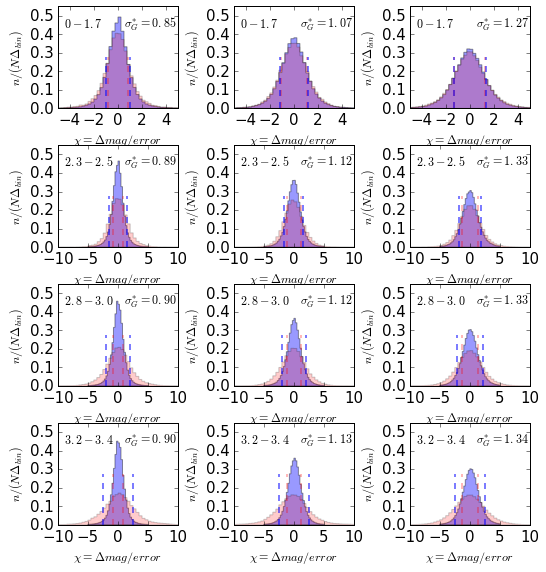

In [61]:
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

fig, axs = plt.subplots(4,3, figsize=(8, 8))
fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.05, top=0.95)

for i in range(len(tau_max_arr)):  # 
    for j in range(len(Min_arr) ):  # 
       

        datafileS = d+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        vS = np.loadtxt(datafileS, unpack=True)
        chiS = vS[0]/vS[2]
        chiSok = chiS[np.abs(chiS)<5]
        
        datafileQ = d+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
                str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        vQ = np.loadtxt(datafileQ, unpack=True)
        chiQ = vQ[0]/vQ[2]
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[i]]

        # plot histograms
        Xlabel = '$\chi = \Delta mag / error$'
        Ylabel = '$n / (N\Delta_{bin})$'
        Xmin = -xlims_arr[i]
        Xmax = xlims_arr[i]
        bins = 40 
        title= r'$ '+' '+ str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'$'
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, Xlabel=Xlabel, Ylabel=Ylabel, ax=axs[i,j],bins=bins,  
                         title=title)

#name = 'poster_r_cut_qso_starsB_histogram_grid.png'
name = 'test_hist.png'
if (name is None):
    plt.show() 
else:
    print 'saving plot to:', name
    plt.savefig(name, bbox_inches='tight')